In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import pickle
import time
from pathlib import Path

import pandas as pd


import torch
from sklearn.metrics import f1_score, hamming_loss

import neurosym as ns
from neurosym.examples import near

LIST_LENGTH = 5

In [2]:
def bce_loss(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Compute the binary cross entropy loss with class weights for the Tiny CalMS21 dataset.
    This is the same loss function used in the base NEAR implementation.

    Args:
        predictions (torch.Tensor): Model predictions with shape (B, T, O).
        targets (torch.Tensor): Ground truth labels with shape (B, T, 1).

    Returns:
        torch.Tensor: The computed binary cross-entropy loss.
    """
    targets = targets.squeeze(-1)  # (B, T, 1) -> (B, T)
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view(-1)
    # pylint: disable=not-callable
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=2)
    # pylint: enable=not-callable
    return torch.nn.functional.binary_cross_entropy_with_logits(
        predictions.float(),
        targets_one_hot.float(),
        weight=torch.tensor([1.0, 1.5], device=predictions.device),
    )

In [3]:
from sklearn.metrics import classification_report

def compute_near_metrics(predictions, ground_truth):
    weighted_avg_f1 = f1_score(predictions, ground_truth, average="weighted")
    unweighted_avg_f1 = f1_score(predictions, ground_truth, average="macro")
    all_f1 = f1_score(predictions, ground_truth, average=None)
    hamming_accuracy = 1 - hamming_loss(ground_truth, predictions)
    report = classification_report(
        ground_truth,
        predictions,
        output_dict=True
    )
    return dict(
        f1_score=weighted_avg_f1,
        unweighted_f1=unweighted_avg_f1,
        all_f1s=all_f1,
        hamming_accuracy=hamming_accuracy,
        report=report
    )

In [ ]:
def run_crim13_experiment(
    output_path: str = "outputs/compression_near_logs/crim13_results.pkl",
):
    """
    Run the NEAR experiment on the CRIM13 dataset.

    Args:
        output_path (str): File path to save the resulting programs list as a pickle file.
    """

    # Prepare data and DSL
    datamodule = ns.datasets.crim13_data_example(train_seed=0, batch_size=1024)
    _, output_dim = datamodule.train.get_io_dims()
    original_dsl = near.simple_crim13_dsl(num_classes=output_dim, hidden_dim=16)

    # Trainer configuration
    trainer_cfg = near.NEARTrainerConfig(
        n_epochs=15,
        lr=1e-3,
        loss_callback=bce_loss,
    )

    neural_dsl = near.NeuralDSL.from_dsl(
        dsl=original_dsl,
        neural_hole_filler=near.GenericMLPRNNNeuralHoleFiller(hidden_size=16),
    )

    cost = near.default_near_cost(
        trainer_cfg=trainer_cfg,
        datamodule=datamodule,
        structural_cost_weight=0.05,
    )

    # Create the NEAR graph
    g = near.near_graph(
        neural_dsl,
        neural_dsl.valid_root_types[0],
        is_goal=lambda _: True,
        cost=cost,
    )

    # Search for programs with bounded A*
    iterator = ns.search.bounded_astar(g, max_depth=10)

    programs_list = []
    start_time = time.time()

    # Collect programs up to LIST_LENGTH
    while True:
        try:
            program = next(iterator)
        except StopIteration:
            break

        timer = time.time() - start_time
        programs_list.append({"program": program, "time": timer})

        if len(programs_list) >= LIST_LENGTH:
            print("Programs list is too long")
            break

    # Optional: Drop into an interactive shell (commented out for module usage)
    # import IPython; IPython.embed()

    # Evaluate each discovered program
    for d in programs_list:
        program = d["program"]
        initialized_program = neural_dsl.initialize(program)
        _ = cost.validation_heuristic.with_n_epochs(40).compute_cost(
            neural_dsl, initialized_program, cost.embedding
        )

        feature_data = datamodule.test.inputs
        labels = datamodule.test.outputs.flatten()

        module = ns.examples.near.TorchProgramModule(neural_dsl, initialized_program)
        predictions = (
            module(torch.tensor(feature_data), environment=())
            .argmax(-1)
            .numpy()
            .flatten()
        )
        metrics = compute_near_metrics(predictions, labels)
        d["report"] = metrics
        d['true_vals'] = labels.tolist()
        d['pred_vals'] = predictions.tolist()

    # Save the programs_list to a pickle file
    with open(output_path, "wb") as f:
        pickle.dump(programs_list, f)

In [6]:
%cd /home/asehgal/neurosym-lib
run_crim13_experiment("outputs/mice_results/crim13_results.pkl")

/home/asehgal/env/miniconda3/envs/neurosym-lib/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/asehgal/neurosym-lib
Training ??::<[{f, 19}] -> [{f, 2}]>
Training (add ??::<[{f, 19}] -> [{f, 2}]> ??::<[{f, 19}] -> [{f, 2}]>)
Training (mul ??::<[{f, 19}] -> [{f, 2}]> ??::<[{f, 19}] -> [{f, 2}]>)
Training (ite ??::<[{f, 19}] -> {f, 1}> ??::<[{f, 19}] -> [{f, 2}]> ??::<[{f, 19}] -> [{f, 2}]>)
Training (map ??::<{f, 19} -> {f, 2}>)
Training (map_prefix ??::<[{f, 19}] -> {f, 2}>)
Training (output ??::<[{f, 19}] -> [{f, 16}]>)
Training (output (add ??::<[{f, 19}] -> [{f, 16}]> ??::<[{f, 19}] -> [{f, 16}]>))
Training (output (mul ??::<[{f, 19}] -> [{f, 16}]> ??::<[{f, 19}] -> [{f, 16}]>))
Training (output (ite ??::<[{f, 19}] -> {f, 1}> ??::<[{f, 19}] -> [{f, 16}]> ??::<[{f, 19}] -> [{f, 16}]>))
Training (output (map ??::<{f, 19} -> {f, 16}>))
Training (output (map_prefix ??::<[{f, 19}] -> {f, 16}>))
Training (output (map (add ??::<{f, 19} -> {f, 16}> ??::<{f, 19} -> {f, 16}>)))
Training (output (map (mul ??::<{f, 19} -> {f, 16}> ??::<{f, 19} -> {f, 16}>)))
Training (output (map (i

In [ ]:
def load_obj(file_path: str) -> object:
    """Load an object from a JSON or pickle file."""
    path = Path(file_path)
    if path.suffix == ".json":
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    elif path.suffix == ".pkl":
        with path.open("rb") as f:
            return pickle.load(f)
    else:
        raise ValueError(f"Unsupported file extension: {path.suffix}")


baseline_results = load_obj("outputs/mice_results/baseline_results.json")
our_results = load_obj("outputs/mice_results/crim13_results.pkl")
our_results = {f"crim13_ours_astar-near_00{i}": our_results[i] for i in range(len(our_results))}
all_results = {**baseline_results, **our_results}

# df1 = (
#     pd.DataFrame(our_results)
#     .assign(
#         program=lambda d: d["program"].map(ns.render_s_expression),
#         method="astar_neurosymlib",
#     )
#     .pipe(lambda d: d.join(d.pop("report").apply(pd.Series)))
#     .round(4)
# )

# df2 = pd.DataFrame(baseline_results).T.reset_index(names=["method"])

# df = pd.concat([df1, df2], ignore_index=True).dropna(axis=1)

# # Display desired columns
# final_df = df[["method", "time", "f1_score", "unweighted_f1", "hamming_accuracy", "program"]]
# final_df

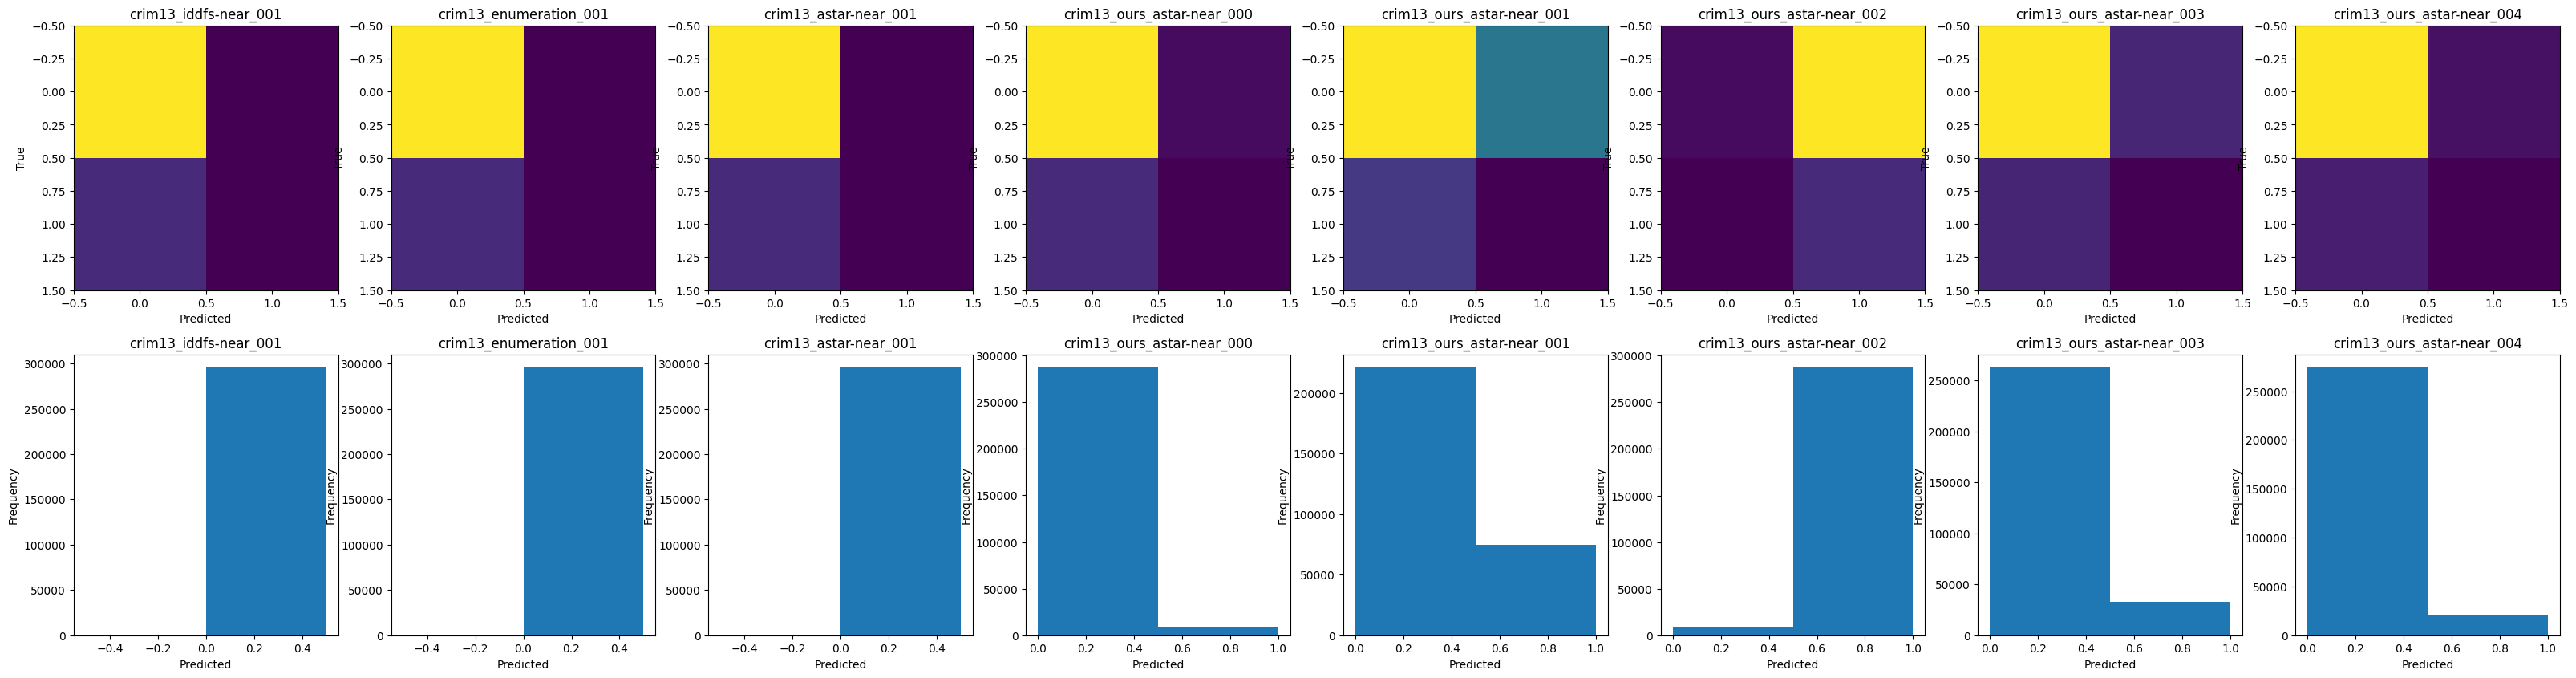

In [39]:
# verify that all_results[k]['true_vals'] are the same
for k in all_results:
    assert all_results[k]['true_vals'] == all_results['crim13_iddfs-near_001']['true_vals']

# construct N confusion matrices
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
for k in all_results:
    confusion_matrices[k] = confusion_matrix(all_results[k]['true_vals'], all_results[k]['pred_vals'])

# plot the confusion matrices

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, len(confusion_matrices), figsize=(5*len(confusion_matrices), 10))

for i, k in enumerate(confusion_matrices):  
    axs[0][i].imshow(confusion_matrices[k], cmap='viridis')
    axs[0][i].set_title(k)
    axs[0][i].set_xlabel('Predicted')
    axs[0][i].set_ylabel('True')

# on axs[1] plot the histogram of the predictions
for i, k in enumerate(confusion_matrices):
    axs[1][i].hist(all_results[k]['pred_vals'], bins=2)
    axs[1][i].set_title(k)
    axs[1][i].set_xlabel('Predicted')
    axs[1][i].set_ylabel('Frequency')

In [64]:
all_reports = {}
for k in all_results:
    if 'ours' in k:
        all_reports[k] = all_results[k]['report']['report']
    else:
        all_reports[k] = all_results[k]['report']
    
    all_reports[k]['macro avg']['time'] = all_results[k]['time']


all_reports = {k: all_reports[k]['macro avg'] for k in all_reports}
df = pd.DataFrame(all_reports).T
print(df.to_markdown())
df.to_csv('outputs/mice_results/crim13_results.csv')

|                            |   precision |   recall |   f1-score |   support |      time |
|:---------------------------|------------:|---------:|-----------:|----------:|----------:|
| crim13_iddfs-near_001      |    0.446849 | 0.5      |   0.471933 |    295300 | 19691.5   |
| crim13_enumeration_001     |    0.446849 | 0.5      |   0.471933 |    295300 |   271.896 |
| crim13_astar-near_001      |    0.446849 | 0.5      |   0.471933 |    295300 |  2275.77  |
| crim13_ours_astar-near_000 |    0.474697 | 0.492653 |   0.476807 |    295300 |   995.11  |
| crim13_ours_astar-near_001 |    0.429837 | 0.36064  |   0.391921 |    295300 |   995.11  |
| crim13_ours_astar-near_002 |    0.525155 | 0.507241 |   0.125868 |    295300 |  1121.04  |
| crim13_ours_astar-near_003 |    0.506807 | 0.507039 |   0.506898 |    295300 |  1174.61  |
| crim13_ours_astar-near_004 |    0.579802 | 0.556334 |   0.564032 |    295300 |  1174.61  |
